# 02_test_LSTM.ipynb

Bu notebook models klasöründeki tüm kayıtlı LSTM modellerini yükler, test verisi üzerinde tahmin yapar, performanslarını hesaplar ve karşılaştırmalı grafikler ile sonuçları görselleştirir.

In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

2025-07-28 22:32:03.624923: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-28 22:32:03.628137: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-28 22:32:03.637514: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753731123.654140  100044 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753731123.658721  100044 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753731123.670534  100044 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
import os, sys

# proje kök dizinini; notebooks/ içinde olduğumuz için bir üst klasör olarak ayarlanacak
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# ardından bunu system path'ine ekleyeceğiz
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.data_prep_lstm import download_data, clean_data, scale_data, create_sequences

## 1. Veri Hazırlama

In [3]:
# indirilecek veri için ayarlamalar
symbol = "AAPL"
start, end = "2010-01-01", "2025-07-09"

# veriyi indirme ve model eğitimi için hazırlama
df = download_data(symbol, start, end)
df = clean_data(df)

# test verisini eğitimden sonra gelen tarihlerle kesin ayır
test_start_date = "2024-01-01"
test_df = df.loc[test_start_date:]

# eğitimde fit edilmiş scaler'ı yükle
scaler_path = os.path.join(project_root, "data", "scaler.save")
scaler = joblib.load(scaler_path)
print(f"Scaler yüklendi: {scaler_path}")

# Test verisini scaler ile dönüştür
scaled_test = scaler.transform(test_df.values)

# Sequence uzunluğunu belirle
seq_length = 60

# Test verisi için sequence oluştur
X_test, y_test = create_sequences(scaled_test, seq_length)

/home/outro/vscode_projects/borsa-aslani/src/data_prep_lstm.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end, progress=False)


Scaler yüklendi: /home/outro/vscode_projects/borsa-aslani/data/scaler.save


## 2. Model Yükleme

In [4]:
import os, glob

# test edilecek modelin yüklenmesi (şuanlık herhangi bir modeli yüklüyor, ama altında farklı hiperparametreler için modeller var)
model_files = glob.glob('../models/*.h5')

print(f"Bulunan modeller ({len(model_files)}):")
for m in model_files:
    print(" -", os.path.basename(m))

Bulunan modeller (6):
 - lstm_seq60_units32_dr0.2_lr0.001_20250710-2314.h5
 - lstm_seq60_units50_dr0.2_lr0.001_20250710-2315.h5
 - lstm_seq30_units32_dr0.2_lr0.001_20250710-2313.h5
 - lstm_seq30_units50_dr0.2_lr0.001_20250710-2318.h5
 - lstm_seq60_units64_dr0.2_lr0.001_20250710-2320.h5
 - lstm_seq30_units64_dr0.2_lr0.001_20250710-2319.h5


## 3. Tahmin ve Ölçek Geri Alımı

In [5]:
results = []

close_min, close_scale = scaler.min_[3], scaler.scale_[3]  # close sütunu indeksi: 3

# burada tüm modelleri tek tek test edeceğiz ve sonuçlarını karşılaştıracağız
for model_path in model_files:
    print(f"\nModel testi: {os.path.basename(model_path)}")
    model = load_model(model_path)
    
    # tahmin
    scaled_pred = model.predict(X_test)
    
    # 'close' price için inverse transform, bu sayede scale edilmiş değerden normal değere ulaşılacak
    # bunu hem gerçek veri üzerinde hem de prediction'lar üzerinde yaptık
    y_test_orig = y_test * (1/close_scale) + close_min
    y_pred_orig = scaled_pred * (1/close_scale) + close_min
    
    # performans metrikleri (her bir model için)
    mse = mean_squared_error(y_test_orig, y_pred_orig)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    
    print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    
    # sonuçları results içine json formatında kaydediyoruz
    results.append({
        "Model Dosyası": os.path.basename(model_path),
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "Tahminler": y_pred_orig  # grafik için saklanacak
    })

2025-07-28 22:32:07.599249: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



Model testi: lstm_seq60_units32_dr0.2_lr0.001_20250710-2314.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


MSE: 33.2977, RMSE: 5.7704, MAE: 4.5590

Model testi: lstm_seq60_units50_dr0.2_lr0.001_20250710-2315.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


MSE: 23.1516, RMSE: 4.8116, MAE: 3.6422

Model testi: lstm_seq30_units32_dr0.2_lr0.001_20250710-2313.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


MSE: 32.4314, RMSE: 5.6949, MAE: 4.3580

Model testi: lstm_seq30_units50_dr0.2_lr0.001_20250710-2318.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


MSE: 25.7645, RMSE: 5.0759, MAE: 3.8118

Model testi: lstm_seq60_units64_dr0.2_lr0.001_20250710-2320.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


MSE: 32.0960, RMSE: 5.6653, MAE: 4.2092

Model testi: lstm_seq30_units64_dr0.2_lr0.001_20250710-2319.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
MSE: 26.5753, RMSE: 5.1551, MAE: 3.8073


# Performans Metrik Karşılaştırması

In [6]:
# tüm modellerin performans metriklerini karşılaştır
results_df = pd.DataFrame(results).drop(columns=["Tahminler"])
results_df = results_df.sort_values("RMSE")
print("\nModellerin Performans Karşılaştırması (RMSE’ye göre sıralı):")
display(results_df)


Modellerin Performans Karşılaştırması (RMSE’ye göre sıralı):


,Model Dosyası,MSE,RMSE,MAE
1,lstm_seq60_units50_dr0.2_lr0.001_20250710-2315.h5,23.151637,4.811615,3.642217
3,lstm_seq30_units50_dr0.2_lr0.001_20250710-2318.h5,25.764479,5.075872,3.811805
5,lstm_seq30_units64_dr0.2_lr0.001_20250710-2319.h5,26.575274,5.155121,3.807297
4,lstm_seq60_units64_dr0.2_lr0.001_20250710-2320.h5,32.096035,5.665336,4.209222
2,lstm_seq30_units32_dr0.2_lr0.001_20250710-2313.h5,32.431358,5.694854,4.358033
0,lstm_seq60_units32_dr0.2_lr0.001_20250710-2314.h5,33.297707,5.770417,4.559025


## 4. forecast_future fonksiyonu İmplementasyonu

In [7]:
def forecast_future(model, last_sequence, days, scaler, feature_index=3):
    """
    model         : eğitilmiş LSTM modeli
    last_sequence : son seq_length günün ölçeklenmiş verisi, shape=(seq_length, n_features)
    days          : kaç adım ileri tahmin yapılacak (ör. 30)
    scaler        : orijinal MinMaxScaler (tüm feature’lar için fit edilmiş)
    feature_index : close price bizim feature index'imiz (3 olacak)
    
    Returns:
    - future_preds_orig: inverse transform yapılmış gelecek günlerin tahminleri (days uzunluğunda array)
    """
    seq = last_sequence.copy()
    preds_scaled = []
    
    for _ in range(days):
        # model.predict bekler: batch-boyutlu 3d array
        p = model.predict(seq[np.newaxis, ...])[0,0]
        preds_scaled.append(p)
        
        # bilinen son günü al
        new_row = seq[-1].copy()
        
        # hedef değişkeni güncelle (örneğin close price, feature_index)
        new_row[feature_index] = p
        
        # en eski günü çıkar ve yeni oluşturulan günü ekle
        seq = np.vstack([seq[1:], new_row])
    
    # scaler.min_, scaler.scale_ içinden sadece target index’ini alıp inverse
    min_val   = scaler.min_[feature_index]
    scale_val = scaler.scale_[feature_index]
    future_preds_orig = np.array(preds_scaled) * (1/scale_val) + min_val
    
    return future_preds_orig


En iyi model: lstm_seq60_units50_dr0.2_lr0.001_20250710-2315.h5 (RMSE=4.8116)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


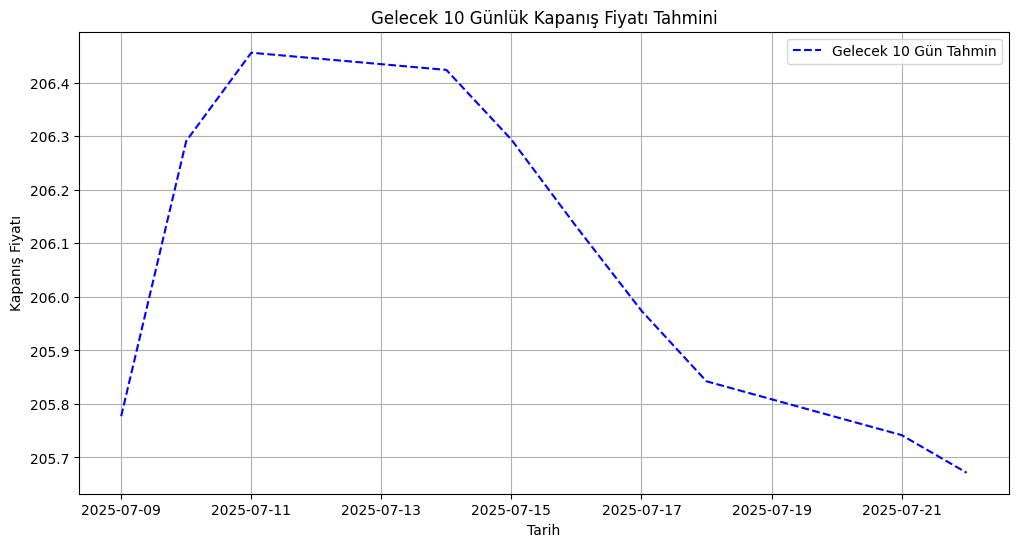

In [8]:
# gelecek 10 günlük tahmin için en iyi modeli kullanacağız
results_df = pd.DataFrame(results)
best_model_row = results_df.loc[results_df['RMSE'].idxmin()]
best_model_path = os.path.join(project_root, "models", best_model_row["Model Dosyası"])
print(f"\nEn iyi model: {best_model_row['Model Dosyası']} (RMSE={best_model_row['RMSE']:.4f})")

best_model = load_model(best_model_path)

days_to_forecast = 10

# scaled_data son hali: scaled_data değişkeni notebook başında zaten tanımlı
# create_sequences ile elde ettiğiniz tüm X dizisinin en son penceresini alıyorum
last_seq = X_test[-days_to_forecast:] if False else X_test[-1]  
# tüm veriden sequence’leri oluşturduğum array. sson sequence X[-1]

future_preds = forecast_future(model, last_seq, days_to_forecast, scaler, feature_index=3)

# zaman eksenini oluşturuyorum
last_date = df.index[-1]  # orijinal DataFrame’in son tarihi
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1),
                             periods=days_to_forecast, freq='B')  # iş günleri

# geçmiş gerçek ve 10 gün tahmin
plt.figure(figsize=(12,6))
plt.plot(future_dates, future_preds, label=f'Gelecek {days_to_forecast} Gün Tahmin', linestyle='--', color='blue')
plt.title(f'Gelecek {days_to_forecast} Günlük Kapanış Fiyatı Tahmini')
plt.xlabel('Tarih')
plt.ylabel('Kapanış Fiyatı')
plt.legend()
plt.grid(True)
plt.show()

## 5. Gerçek vs Tahmin Grafiği

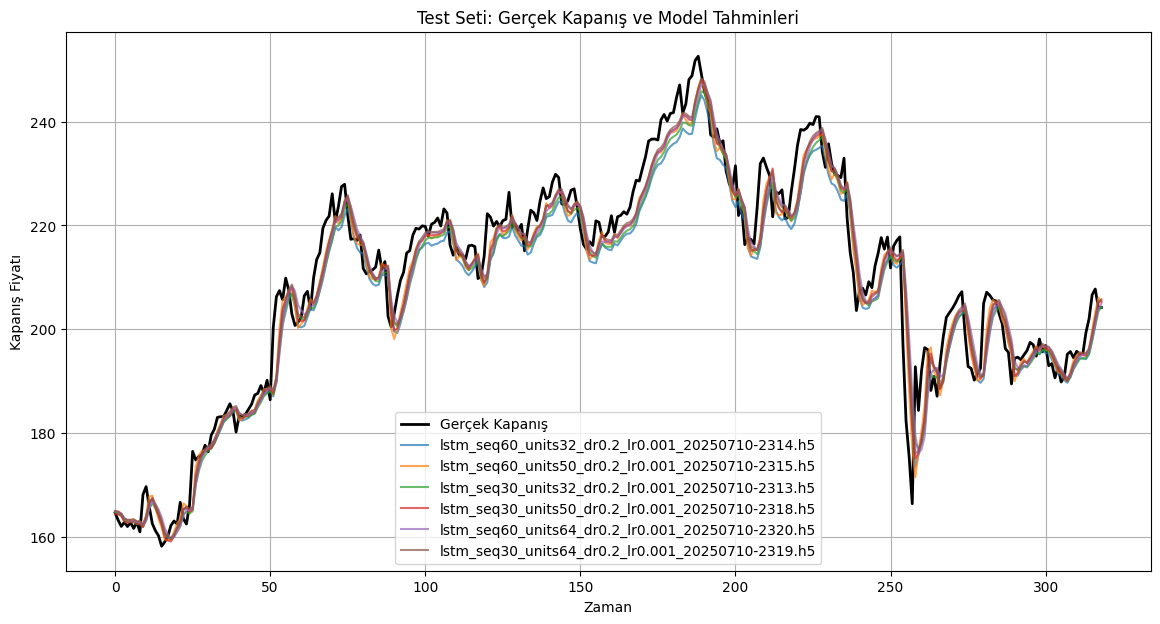

In [9]:
plt.figure(figsize=(14,7))
plt.plot(y_test_orig, label="Gerçek Kapanış", color='black', linewidth=2)

for r in results:
    plt.plot(r["Tahminler"], label=r["Model Dosyası"], alpha=0.7)
    
plt.title("Test Seti: Gerçek Kapanış ve Model Tahminleri")
plt.xlabel("Zaman")
plt.ylabel("Kapanış Fiyatı")
plt.legend()
plt.grid(True)
plt.show()